In [1]:
from soxs.utils import soxs_cfg
soxs_cfg.set('soxs', 'bkgnd_nH', '0.018')
import soxs

soxs : [WARNING  ] 2024-05-21 15:46:25,642 Setting 'soxs_data_dir' to /u/madepa/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [5]:
import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

In [20]:
basePath = '/virgotng/universe/IllustrisTNG/TNG100-1/output'

halo = il.groupcat.loadSingle(basePath, 99, haloID=7)

In [21]:
#fields = ['Coordinates','GFM_CoolingRate','Density','InternalEnergy','ElectronAbundance','StarFormationRate']
gas = il.snapshot.loadHalo(basePath, 99, 144, 'gas')
header = il.groupcat.loadHeader(basePath, 99)

with h5py.File(il.snapshot.snapPath(basePath, 99),'r') as f:
    header_snap = dict(f['Header'].attrs)

In [5]:
filename = "../data/mockhalo_144.hdf5"
with h5py.File(filename,'w') as f:
    for key in gas.keys():
        f['PartType0/' + key] = gas[key]
        
    # some metadata that yt demands
    f.create_group('Header')
    f['Header'].attrs['NumFilesPerSnapshot'] = 1
    f['Header'].attrs['MassTable'] = header_snap['MassTable']
    f['Header'].attrs['BoxSize'] = header['BoxSize']
    f['Header'].attrs['Time'] = header['Time']
    f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
    
    # Must have the next six for correct units
    f["Header"].attrs["HubbleParam"] = header["HubbleParam"]
    f["Header"].attrs["Omega0"] = header["Omega0"]
    f["Header"].attrs["OmegaLambda"] = header["OmegaLambda"]

    # These correspond to the values from the simulations
    f["Header"].attrs["UnitLength_in_cm"] = header_snap['UnitLength_in_cm']
    f["Header"].attrs["UnitMass_in_g"] = header_snap['UnitMass_in_g']
    f["Header"].attrs["UnitVelocity_in_cm_per_s"] = header_snap['UnitVelocity_in_cm_per_s']

In [11]:
def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 10**5
    pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
    pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
    return (pfilter1 & pfilter2) & pfilter3

yt.add_particle_filter("hot_gas", function=hot_gas, filtered_type='gas', requires=["temperature","density"])

In [12]:
ds.add_particle_filter("hot_gas")

yt : [INFO     ] 2024-05-21 15:47:57,456 Allocating for 1.986e+07 particles
Loading particle index: 100%|█████████████████| 76/76 [00:00<00:00, 4177.76it/s]


True

In [23]:
filename = "../data/yt_halodata/mockhalo_TNG100_7.hdf5"
ds = yt.load(filename)

yt : [INFO     ] 2024-05-21 15:55:19,872 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2024-05-21 15:55:19,882 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2024-05-21 15:55:19,972 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2024-05-21 15:55:19,973 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-21 15:55:19,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-21 15:55:19,974 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2024-05-21 15:55:19,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-05-21 15:55:19,975 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-05-21 15:55:19,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-05-21 15:55:19,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-05-21 15:55:19,976 Parameters: omega_radiation           =

In [30]:
c = ds.arr([halo["GroupPos"][0], halo["GroupPos"][1], halo["GroupPos"][2]], "code_length")
r = halo['Group_R_Crit200']/0.6774

yt : [INFO     ] 2024-05-21 15:59:52,322 xlim = 36133.423671 37410.560704
yt : [INFO     ] 2024-05-21 15:59:52,322 ylim = 298.964869 1576.101903
yt : [INFO     ] 2024-05-21 15:59:52,330 xlim = 36133.423671 37410.560704
yt : [INFO     ] 2024-05-21 15:59:52,331 ylim = 298.964869 1576.101903
yt : [INFO     ] 2024-05-21 15:59:52,333 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



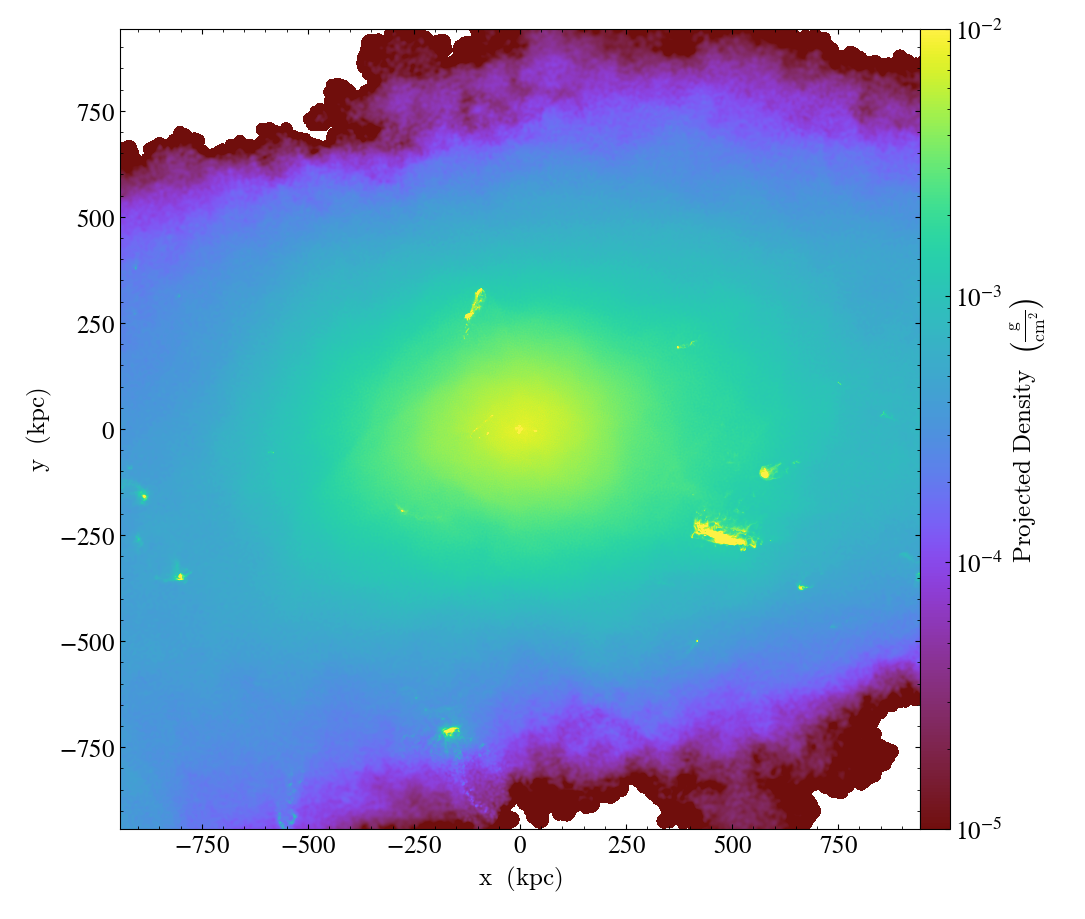

In [32]:
prj = yt.ProjectionPlot(ds, "z", ('gas','density'), center=c, width=(2*r, 'kpc'))
prj.set_zlim(("gas","density"), 1.0e-5, 10**-2)

yt : [INFO     ] 2024-05-21 16:53:14,239 xlim = 34856.286637 38687.697738
yt : [INFO     ] 2024-05-21 16:53:14,239 ylim = -978.172164 2853.238937
yt : [INFO     ] 2024-05-21 16:53:14,242 xlim = 34856.286637 38687.697738
yt : [INFO     ] 2024-05-21 16:53:14,243 ylim = -978.172164 2853.238937
yt : [INFO     ] 2024-05-21 16:53:14,244 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



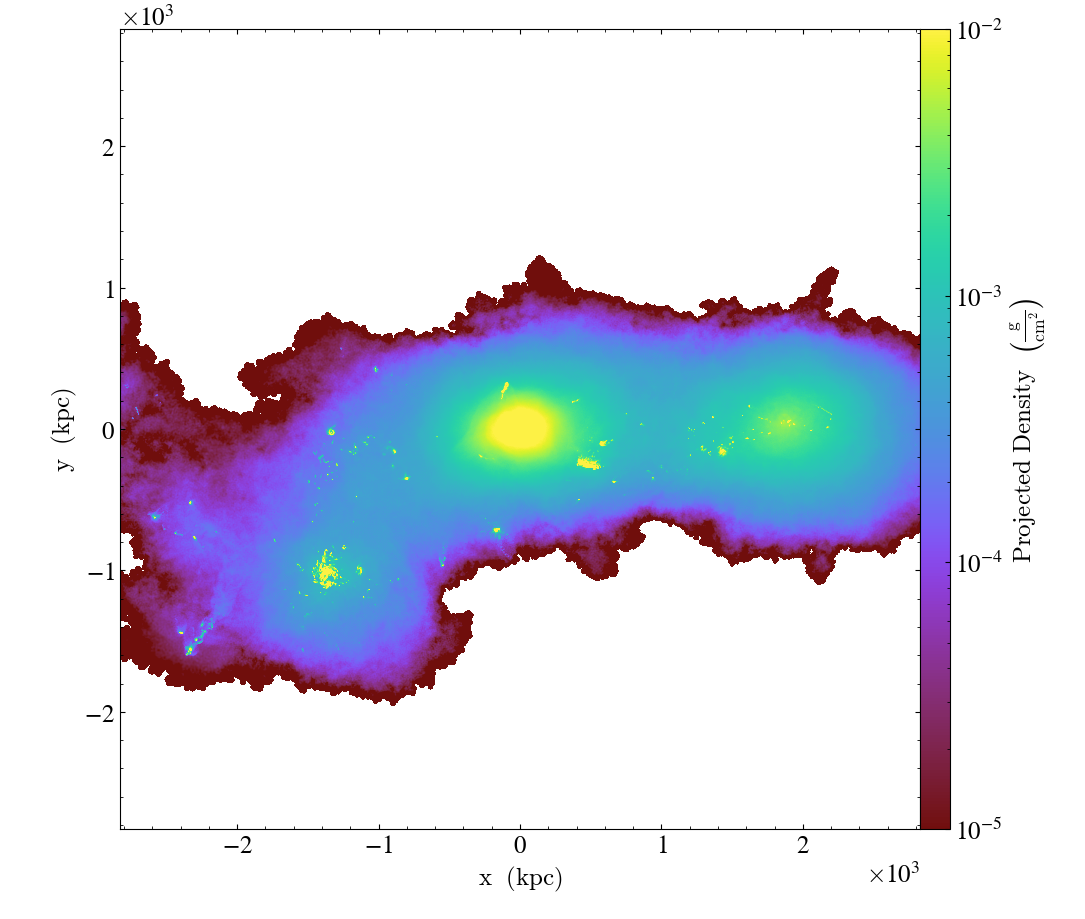

In [39]:
prj = yt.ProjectionPlot(ds, "z", ('gas','density'), center=c, width=(6*r, 'kpc'))
prj.set_zlim(("gas","density"), 1.0e-5, 10**-2)

yt : [INFO     ] 2024-05-17 07:27:07,934 xlim = 55027.071163 56043.171025
yt : [INFO     ] 2024-05-17 07:27:07,934 ylim = 7174.862178 8190.962040
yt : [INFO     ] 2024-05-17 07:27:07,938 xlim = 55027.071163 56043.171025
yt : [INFO     ] 2024-05-17 07:27:07,938 ylim = 7174.862178 8190.962040
yt : [INFO     ] 2024-05-17 07:27:07,939 Making a fixed resolution buffer of (('hot_gas', 'density')) 800 by 800



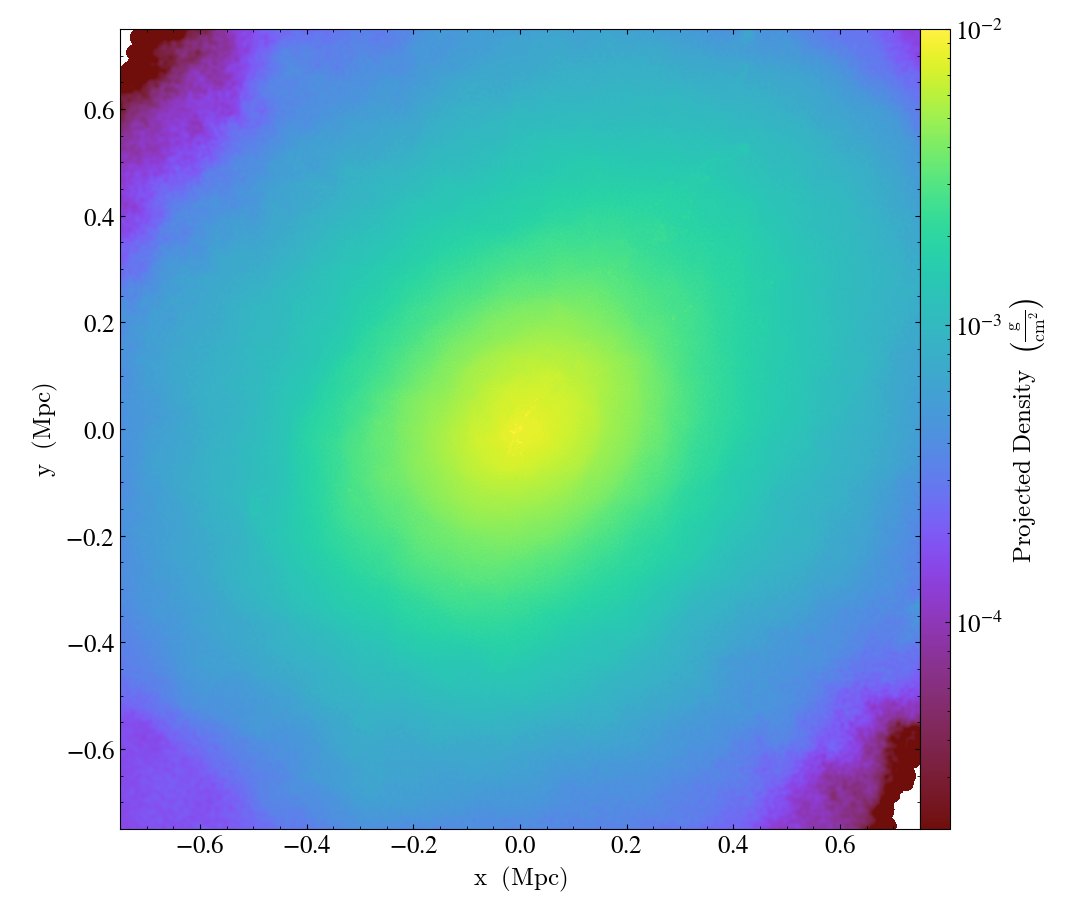

In [13]:
prj = yt.ProjectionPlot(ds, "z", ("hot_gas","density"), width=(1.5, "Mpc"), center=c)
prj.set_zlim(("hot_gas","density"), 2.0e-5, 1.0e-2)

In [15]:
emin = 0.05
emax = 4.0
nbins = 4000
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"))

pyxsim : [INFO     ] 2024-05-17 07:28:10,591 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-05-17 07:28:10,593 kT_max = 64 keV


In [16]:
exp_time = (800., "ks") # exposure time
area = (5000.0, "cm**2") # collecting area
redshift = 0.025

In [17]:
width = ds.quan(1.5, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)

In [20]:
n_photons, n_cells = pyxsim.make_photons(f"halo_144_photons", box, redshift, area, exp_time, source_model)

pyxsim : [INFO     ] 2024-05-05 07:32:38,486 Cosmology: h = 0.6774, omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2024-05-05 07:32:38,488 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2024-05-05 07:32:38,488 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/713997 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-05 07:34:21,720 Finished generating photons.
pyxsim : [INFO     ] 2024-05-05 07:34:21,721 Number of photons generated: 14792851
pyxsim : [INFO     ] 2024-05-05 07:34:21,722 Number of cells with photons: 701897


In [21]:
n_events = pyxsim.project_photons(f"halo_144_photons", f"halo_144_events", "z", (45.,30.), absorb_model="wabs", nH=0.01)

pyxsim : [INFO     ] 2024-05-05 07:34:26,032 Foreground galactic absorption: using the wabs model and nH = 0.01.


Projecting photons from cells/particles :   0%|          | 0/701897 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-05-05 07:34:28,171 Detected 1796533 events.


In [22]:
events = pyxsim.EventList(f"halo_144_events.h5")
events.write_to_simput(f"halo_144", overwrite=True)

soxs : [WARNING  ] 2024-05-05 07:34:31,596 Overwriting halo_144_phlist.fits.
soxs : [INFO     ] 2024-05-05 07:34:31,662 Writing source 'halo_144' to halo_144_phlist.fits.


In [18]:
instrument = "lem_outer_array"
soxs.instrument_simulator(f"halo_144_simput.fits", f"halo_144_evt.fits", (500.0, "ks"), instrument, (45.,30.), overwrite=True, foreground=False, ptsrc_bkgnd=False)

soxs : [INFO     ] 2024-05-17 07:29:14,407 Making observation of source in halo_14_evt.fits.
soxs : [INFO     ] 2024-05-17 07:29:17,081 Detecting events from source halo_14.
soxs : [INFO     ] 2024-05-17 07:29:17,082 Applying energy-dependent effective area from lem_300522.arf.
soxs : [INFO     ] 2024-05-17 07:29:24,631 Pixeling events.
soxs : [INFO     ] 2024-05-17 07:29:27,187 Scattering events with a gaussian-based PSF.
soxs : [INFO     ] 2024-05-17 07:29:27,993 9619206 events were detected from the source.
soxs : [INFO     ] 2024-05-17 07:29:28,660 Scattering energies with RMF lem_2.5ev_110422.rmf.


Scattering energies :   0%|          | 0/9619206 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-05-17 07:30:26,329 Adding background events.
soxs : [INFO     ] 2024-05-17 07:30:26,674 Adding in instrumental background.
soxs : [INFO     ] 2024-05-17 07:30:26,817 Making 1706321 events from the instrumental background.
soxs : [INFO     ] 2024-05-17 07:30:27,107 Writing events to file halo_14_evt.fits.
soxs : [INFO     ] 2024-05-17 07:30:29,737 Observation complete.


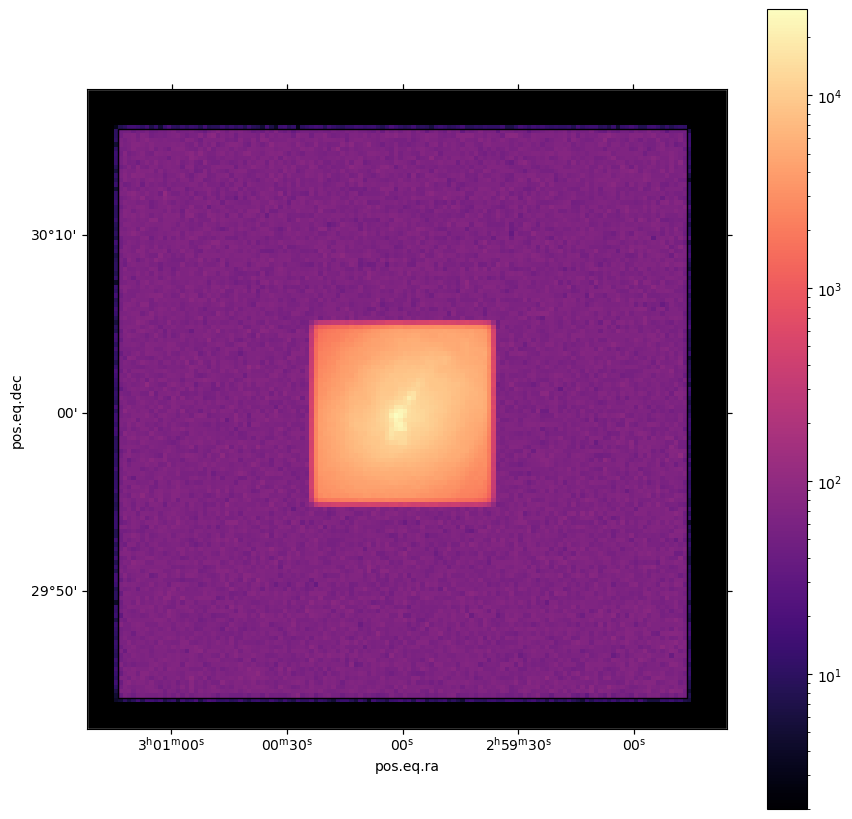

In [23]:
soxs.write_image(f"halo_144_evt.fits", f"halo_144_img.fits", emin=0.1, emax=2.0, overwrite=True)
center_sky = SkyCoord(45, 30, unit='deg', frame='fk5')
region_sky = RectangleSkyRegion(center=center_sky, width=32 * u.arcmin, height=32*u.arcmin)
with fits.open(f"halo_144_img.fits") as f:
    w = wcs.WCS(header=f[0].header)
    fig, ax = soxs.plot_image(f"halo_144_img.fits", stretch='log', cmap='magma', width=0.6)
ax.add_artist(region_sky.to_pixel(w).as_artist())

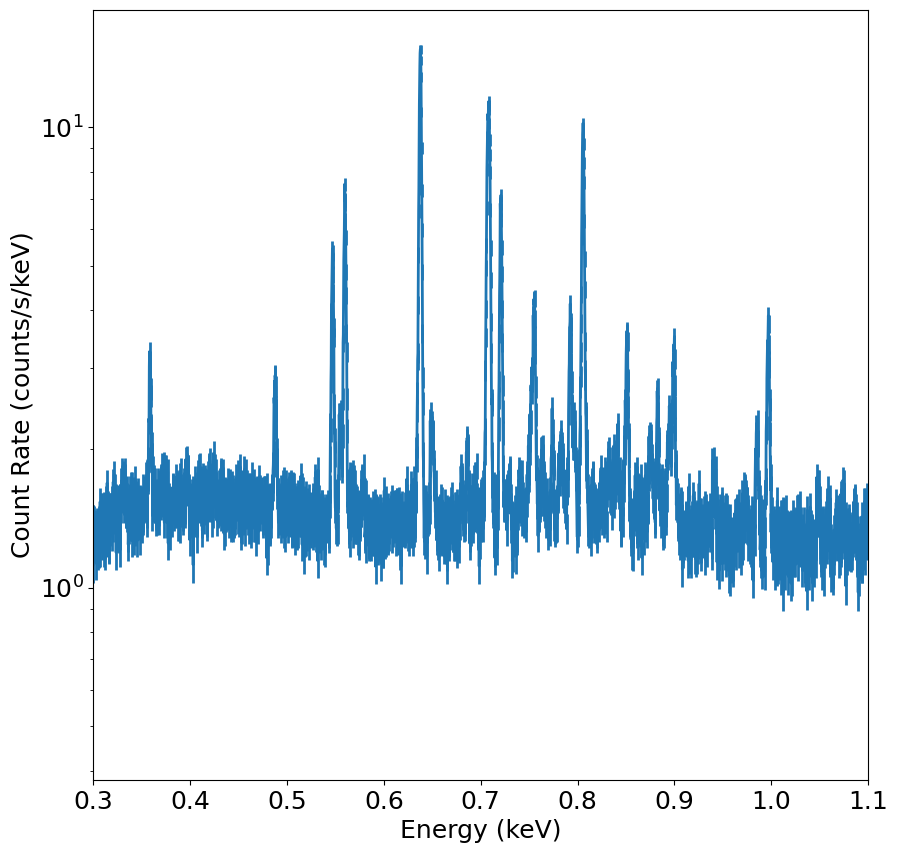

In [25]:
soxs.write_spectrum(f"halo_144_evt.fits", f"halo_144_evt.pi", overwrite=True)
fig, ax = soxs.plot_spectrum(f"halo_144_evt.pi", xmin=0.3, xmax=1.1, xscale="linear")